# Nload
Author: Adrian Wiegman, USDA-ARS (adrian.wiegman@usda.gov)

## Contents 

section | description 
---|---
overview | general description of the model and basic instructions
user input | section for user control of model runs
environment | input and output control 
functions | functions for calculating variables in Nload
model | the Nload model code
implementations | various scenarios and run commands for the Nload model

## Overview

This notebook contains functions and algorithms to calculate watershed Nitrogen loading to the surface water of a recieving body in characterized by groundwater flow in coarse glacial sediments (Valiela et al. 1997, 2000) and where cranberry production makes up a the majority of agricultural land area. 

The original nitrogen loading model model was developed by Valiela et al. (1997, 2000) then adapted by Williamson et al. 2017. Kennedy and Hoesktra 2021, modified the model of Williamson et al. 2017 to adjust for areas of cranberry production and to distinguish between flow-through (FT) and non-flow-through (NFT) cranberry beds. 

The application of the model here builds upon Kennedy and Hoesktra by allowing for variation in fertilizer application rates for cranberry production, and restoration of cranberry bogs that fall at the terminus of a subwatershed (figure 1). 

Each of the remaining sections in this notebook will begin with a "Markdown" block, containing general description and basic instructions. The Markdown block is followed by a "Code" block where the user can edit or modify the program based on their needs. 

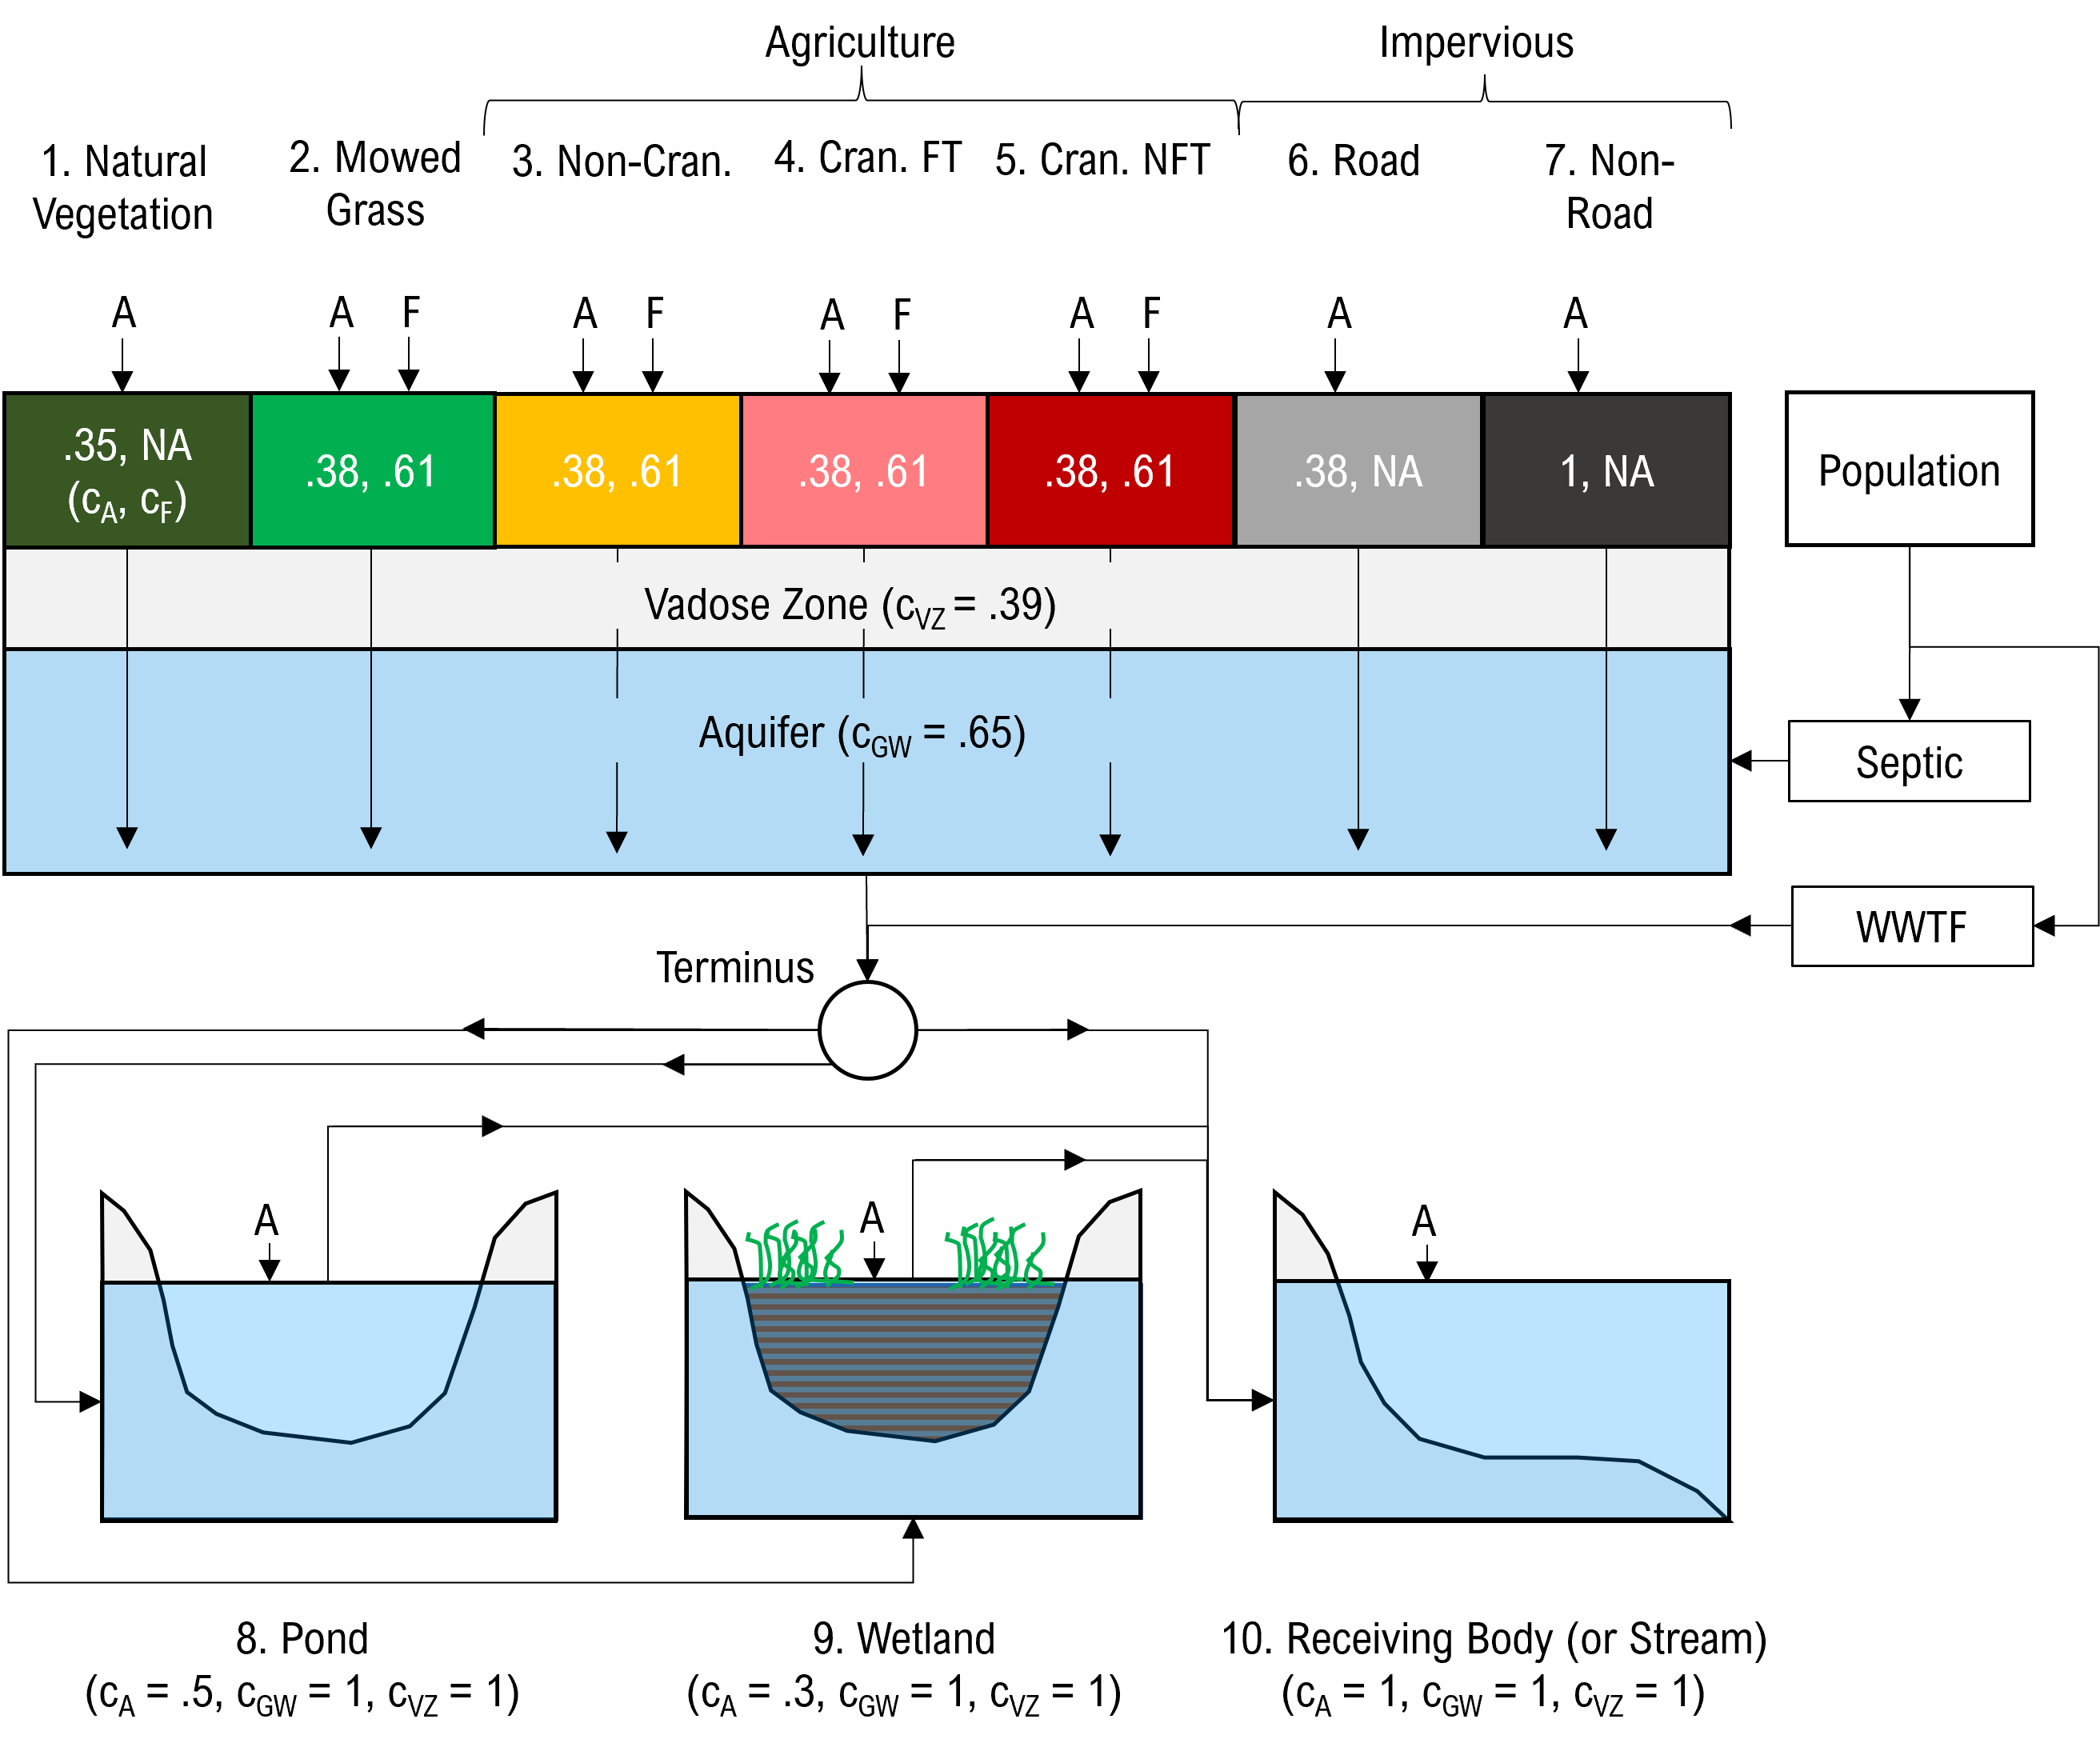
*Figure 1. Conceptual diagram of Nitrogen Mass flow in Nload.*



## User Input

User inputs are devided into two code blocks:
1. required user inputs (data files required to run the model)
2. optional inputs (e.i. changing parameter values from defaults)

### Required inputs 

At a mininum, users must supply a file path (text string "C:/path/to/terminus/classes/") of two input tables (in `.csv` format): 
1. one with the terminus classification for each sub-catchment (Table 1)
2. the other containing area of each land use classes (LUC) for each subwatershed and named (Table 2).

*Table 1. Minimum Requirements for Input Table of Subcatchment*

| SUB | Terminus | Population_Fraction |
| --- | --- | --- | 
| 0   | NA  | NA  | 

Where: 
- `SUB` is the subcatchment ID number. 
- `Terminus` is the type of hydrologic feature that the subcatchment drains to. 
- `Population_Fraction` is the fraction of the total population of the watershed that lives (and discharges waste) within a given subcatchment

The terminus of the subcatchment must be classified as either, estuary (e) stream (s), pond (p), wetland (w). If the terminus is not classified (e.g. blank or `NA`), the model assumes that the subcatchment discharges directly into the recieving body (ex: Buzzards Bay). The recieving body should always be included, and have a `SUB` value of 0. 

*Table 2. Mininum Requirements for Table of Area of Land Use Classes in Subcatchments*

| SUB | LUC | Area_Ha | 
| --- | --- | --- |
| 0   | 11  | 1   | 

Where: 

- `LUC` is the land use classification code ranging from 1 to 1 (see table 3)
- `Area_Ha` is the surface area (Hectares) of the given land use class within the given sub catchment
 
See appendix for tables with parameters and values for land use classes. see `Preprossesing.ipynb` for methods to convert available land cover data into the classes listed in table 3. 

In [22]:
### Enter Required User Inputs
### Subcatchment terminus classifications
#fpath_SUB_terminus = "C:/path/to/sub/terminus/classes/"
fpath_terminus = r'C:\Workspace\Geodata\Nload\inputs\SUB_terminus.csv'
### Subcatchment land use class area
#fpath_LUC_areas = "C:/path/to/sub/luc/areas/"
fpath_area = r'C:\Workspace\Geodata\Nload\inputs\SUB_LUC_area.csv'

### Optional Inputs

The user may declare values for any of the following parameters in the code chunk below


*Table 4. default parameters*
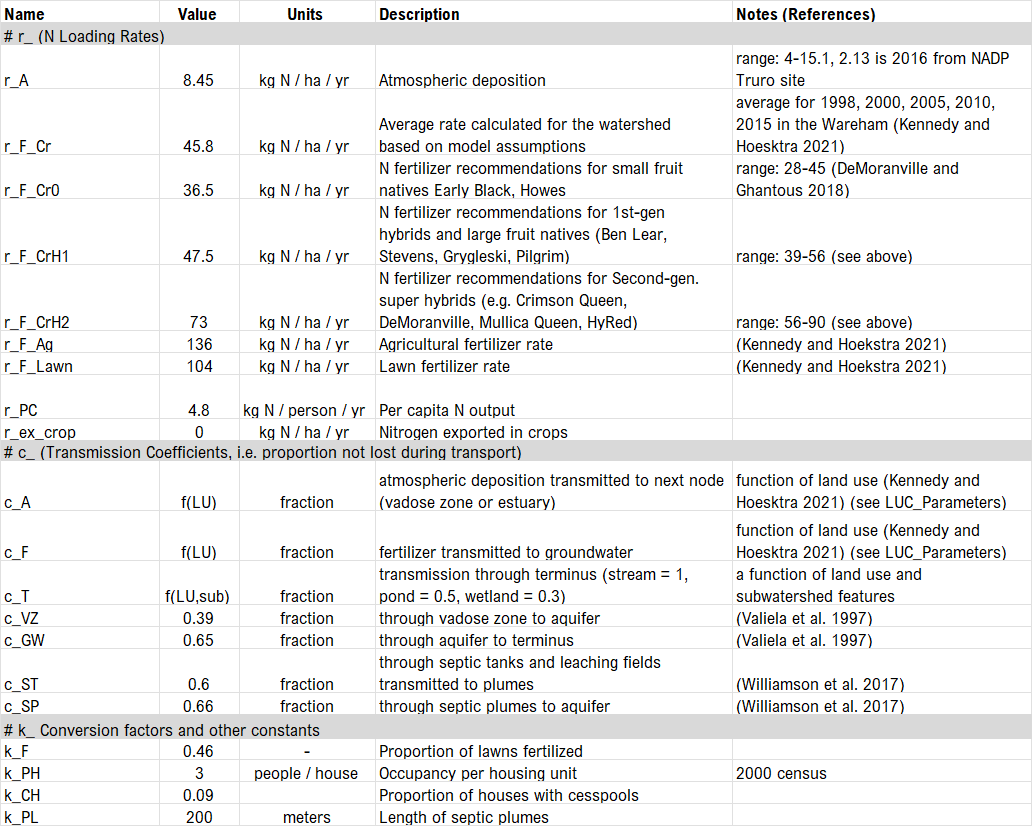

In [ ]:
### Enter Optional User Inputs Here
r_A = 4

In [125]:
# r_ (N Loading Rates) 
r_A = 8.45
r_F_Cr = 45.8
r_F_Ag = 136
r_F_Lawn = 104
r_PC = 4.8
r_ex_crop = 0
# c_ (Transmission Coefficients, i.e. proportion not lost during transport) 
c_A = 0.38
c_F = 0.61
c_T_s = 1
c_T_w = 0.3
c_T_p = 0.5
c_VZ = 0.39
c_GW = 0.65
c_ST = 0.6
c_SP = 0.66
c_WW = 0.2
# k_ Conversion factors and other constants
k_F = 0.46
k_PH = 3
k_CH = 0.09
k_PL = 200
k_WW = 


## Environment

load required function libraries, set up path for output files, and read input files, 

In [120]:
# LOAD FUNCTION LIBRARIES ***************************************
#import arcpy as ap
import os #,glob, re, sys
import pandas as pd
import numpy as np
#import scipy.stats

# SET WORKING DIRECTORY ******************************
# working directory this should be where arcgis project is located
wdr = "C:\\Workspace\\Geodata\\Nload\\"
# output directory
odr = os.path.join(wdr,'outputs')
if not os.path.exists(odr): os.mkdir(odr)
    
# READ INPUT FILES *************************************
# subcatchment terminus classes
df_terminus = pd.read_csv(fpath_terminus)
print("\n\n\nSubcatchment Terminus Classes")
display(df_terminus)
print("Checking for required columns...")
print("SUB","SUB" in df_terminus.columns.values.tolist())
print("Terminus","Terminus" in df_terminus.columns.values.tolist())

# land use area by subcatchment
df_area = pd.read_csv(fpath_area)
print("\n\n\nArea of Land Use Classes Within Subcatchments")
display(df_area)
print("Checking for required columns...")
print("SUB","SUB" in df_area.columns.values.tolist())
print("LUC","LUC" in df_area.columns.values.tolist())
print("Area","Area" in df_area.columns.values.tolist())




Subcatchment Terminus Classes


,SUB,Terminus
0,1,s
1,2,p


Checking for required columns...
SUB True
Terminus True



Area of Land Use Classes Within Subcatchments


,SUB,LUC,Area
0,1,1,0
1,1,2,1
2,1,3,0
3,2,1,1
4,2,2,0
5,2,3,1


Checking for required columns...
SUB True
LUC True
Area True


## Functions

declare user defined functions

In [ ]:
# merges input tables on SUB  
df = pd.merge(df_area, df_terminus, on = "SUB", how = "left")

In [124]:
df['c_T'] = np.where(df['Terminus']=="s",
                     c_T_s,
                     np.where(df['Terminus']=="w", c_T_w,
                              np.where(df['Terminus']=="p",
                                       c_T_p,
                                       c_T_s)))

NameError: name 'c_T_s' is not defined

## Model

In [103]:
SUBs = df_terminus.SUB.unique().tolist()
LUCs = df_area.LUC.unique().tolist()



,SUB,Terminus,LUC,Area
0,1,s,1,0
1,1,s,2,1
2,1,s,3,0
3,2,p,1,1
4,2,p,2,0
5,2,p,3,1


In [ ]:
# TEMPLATE CODE  RESUME HERE 5/31/22
for i in list(dict1.keys()):
    x = df.loc[df.col1==i].col2
    y = dict1[i]
    x*y
    


In [89]:
L = dict()
# LOOP THROUGH SUBs ***************************************
for sub in SUBs:
    # LOOP THROUGH LUCs ***************************************
    for luc in LUCs: 
        # MULTIPLY N LOADING RATE BY LAND AREA FOR EACH LAND USE 
        # SUM N LOAD FOR EACH LAND USE
        L[sub] = L[sub] + LR[luc] * Area[sub,luc]

### ADJUST N LOAD FOR TERMINUS ATTENUATION

## SUM N LOAD 

NameError: name 'L' is not defined

## Implementation

In [6]:
### READ INPUT FILES
import pandas as pd
### MODIFY PARAMETER VALUES

### CALCULATE NLoad

### SAVE OUTPUTS
csv = 

AttributeError: module 'pandas' has no attribute 'reac'

## Appendix



*Table 3. Description of land use classes*

LUC | Land Use Description
---|---
1	| Natural Vegetation
2	| Turf (Lawns & Golf Courses)
3	| Agriculture Cranberry NFT
4	| Agriculture Cranberry FT
5	| Agriculture Non-cranberry
6	| Impervious Buildings & Driveways
7	| Impervious Roads & Parking lots
8	| Freshwater Ponds and Lakes
9	| Wetlands
10	| Estuary
11	| Retired Cranberry

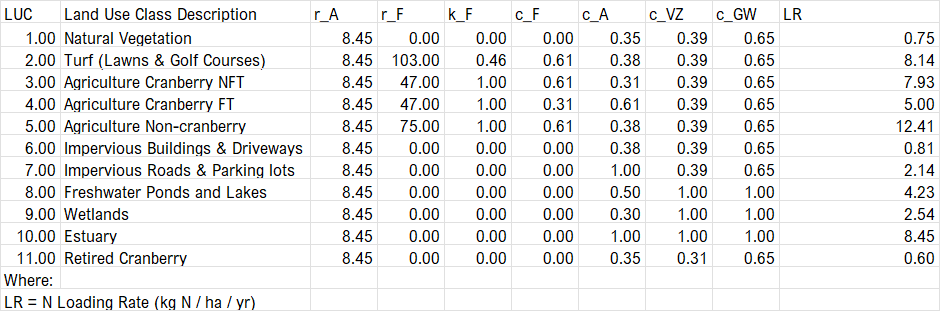

